## 1. Setup

### 1.1 Install and import dependencies

In [13]:
#@title Install and import dependencies
import math
import random, numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa
import librosa.display
import IPython.display
import keras
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
import soundfile as sf
from pathlib import Path
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer

### 1.2 Load existing model (optional)

**Warning: if loading an existing model, skip to Generation after you do so** 

In [14]:
load_existing = False
 
if load_existing:
  name = "model-name"
  path = "/content/drive/MyDrive/GrainModelling/models/"

  config_path = path + f"/{name}_config.json"
  dict_path = path + f"/{name}_frames.json"
  features_path = path + f"/{name}_features.json"
  model_path = path + f"/{name}.keras"

  config = json.load(open(config_path))
  sr = config['sr']
  n_classes = config['n_classes']
  onset_detection = config['onset_detection']
  labelled_frames = json.load(open(dict_path))
  encoded_features = json.load(open(features_path))
  model = keras.models.load_model(model_path)

## 2. Data preprocessing

In [27]:
file_path = "/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/audio-data/oishi.mp3"
block_length = 1
# frame_length_s = 1
BPM = 120
beat = 1/32
frame_length_s = (4 * beat * 60 / BPM)
hop_length_s = frame_length_s * (1/8)

PLOT = 0

sr = librosa.get_samplerate(file_path)
frame_length = math.ceil(frame_length_s * sr)
hop_length = math.ceil(hop_length_s * sr)
stream = Streamer(file_path, block_length, frame_length, hop_length)

print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

FileNotFoundError: [Errno 2] No such file or directory: '~/GS/MC/MC-FP/MC-FP-master/audio-data/oishi.mp3'

### 2.1 Extract features

In [16]:
def extract_features(y, sr):
    if y.size >= 2048:  
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False) # mfccs
    else:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
    m_mfccs = np.median(mfccs, axis=1)
    if m_mfccs.size == 0:
        print("Empty frame!")
    return m_mfccs

In [17]:
features = np.array([extract_features(block, sr) for block in stream.new()])
print(features.shape)
print(features[0])
features_scaled = preprocessing.scale(features, axis=1)
print(features_scaled.shape)
print(features_scaled.min(axis=0))
print(features_scaled.max(axis=0))
print(features_scaled[0]) # type: ignore

if PLOT:
  plt.scatter(features_scaled[:,0], features_scaled[:,1]) # type: ignore
  plt.xlabel('Zero Crossing Rate (scaled)')
  plt.ylabel('Spectral Centroid (scaled)')    

(136073, 13)
[-749.2355     134.30649    -25.039768    52.0735     -13.11018
   15.384638    -2.1688166   13.208666     8.4581175   12.735643
  -29.439507    20.341125   -16.304989 ]
(136073, 13)
[-3.4050226   0.3129007  -1.9535409  -0.11154039 -1.4149432  -0.35969034
 -0.9986249  -0.48234144 -0.8002847  -0.40090096 -0.6536405  -0.2525264
 -0.68852013]
[-0.26240107  3.1005118   0.46615106  1.9806654   0.6793515   1.2955072
  0.42471802  1.0225414   0.5426323   0.67675406  0.5611855   0.6449578
  0.50758857]
[-3.3974278   0.86213523  0.09392568  0.46568942  0.15143833  0.2888121
  0.20418674  0.27832168  0.25541925  0.27604127  0.07271451  0.31270736
  0.13603613]


/Users/wwerkowicz/miniconda/envs/cpu/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/wwerkowicz/miniconda/envs/cpu/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


### 2.2 Cluster

In [18]:
n_classes = 256 #@param {type: "integer"} only applies to kmeans
# frames = [frame for frame in frames if frame.size != 0] # remove empty
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)

n_labels = len(np.unique(labels))
print(f"Total labelled frames: {len(labels)}")
print(f"n_labels: {n_labels} (sanity check)")
labels = labels.tolist()

Total labelled frames: 136073
n_labels: 256 (sanity check)


In [19]:
frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
frames # sanity check

[[0, 3000],
 [375, 3375],
 [750, 3750],
 [1125, 4125],
 [1500, 4500],
 [1875, 4875],
 [2250, 5250],
 [2625, 5625],
 [3000, 6000],
 [3375, 6375],
 [3750, 6750],
 [4125, 7125],
 [4500, 7500],
 [4875, 7875],
 [5250, 8250],
 [5625, 8625],
 [6000, 9000],
 [6375, 9375],
 [6750, 9750],
 [7125, 10125],
 [7500, 10500],
 [7875, 10875],
 [8250, 11250],
 [8625, 11625],
 [9000, 12000],
 [9375, 12375],
 [9750, 12750],
 [10125, 13125],
 [10500, 13500],
 [10875, 13875],
 [11250, 14250],
 [11625, 14625],
 [12000, 15000],
 [12375, 15375],
 [12750, 15750],
 [13125, 16125],
 [13500, 16500],
 [13875, 16875],
 [14250, 17250],
 [14625, 17625],
 [15000, 18000],
 [15375, 18375],
 [15750, 18750],
 [16125, 19125],
 [16500, 19500],
 [16875, 19875],
 [17250, 20250],
 [17625, 20625],
 [18000, 21000],
 [18375, 21375],
 [18750, 21750],
 [19125, 22125],
 [19500, 22500],
 [19875, 22875],
 [20250, 23250],
 [20625, 23625],
 [21000, 24000],
 [21375, 24375],
 [21750, 24750],
 [22125, 25125],
 [22500, 25500],
 [22875, 25875

In [20]:
# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an odd index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
print(len(labelled_frames[0])) # sanity check
print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

1130
1125 4125


------------------
Label:  0
Random index: 36
40500


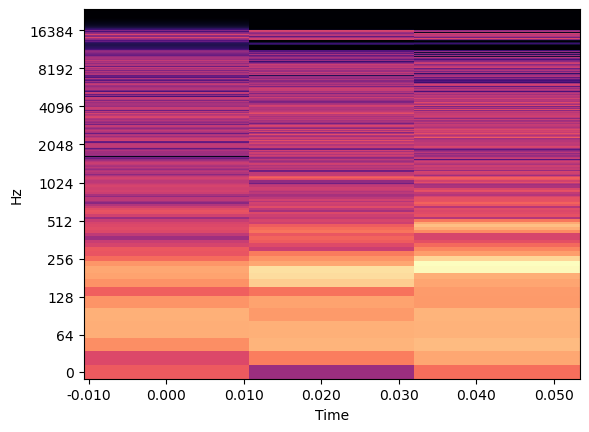

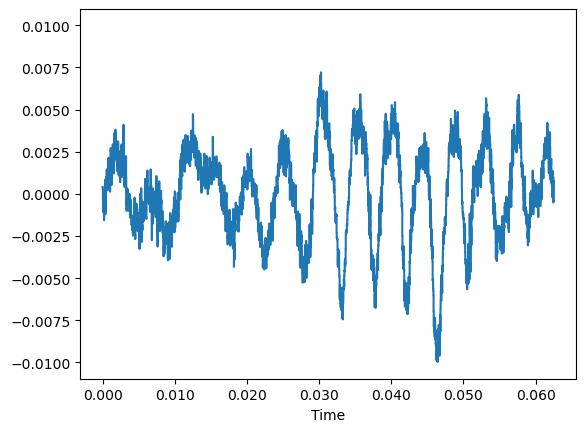

------------------
Label:  1
Random index: 312
41960625


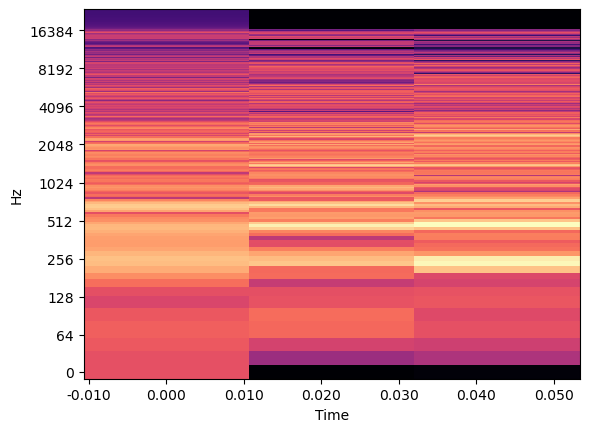

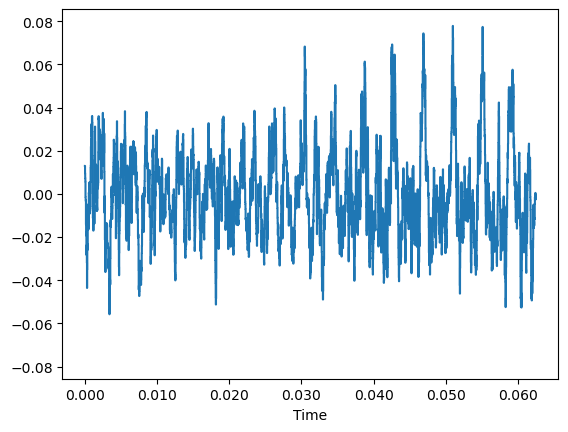

In [21]:
# preview cluster plots
plot = 2
for i in range(plot):
    print("------------------")
    print("Label: ", i)
    f = stream.get_frame(dictionary=labelled_frames, label=i)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(f, hop_length=1024)),
                            ref=np.max) # type: ignore
    librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=1024,
                        x_axis='time')
    plt.show()
    librosa.display.waveshow(f, sr=sr) # display the waveform
    plt.show()
    display(IPython.display.Audio(f, rate=sr)) # play audio file using ipython display
    plt.show()

## 3. Training

In [22]:
######## TODO: Implement K-Fold validation

epochs = 3 #@param {type: "integer"} training epochs
batch_size = 64 #@param {type: "integer"} training batch size
maxlen = n_classes # length of the input sequence window
step = 2 #@param {type: "integer"} step size for the sliding window
hidden_units = 24 #@param {type: "integer"} number of hidden units in the GRU layer
callback = False #@param {type: "boolean"}
#@markdown ---
#@markdown **TODO:**\
#@markdown K-Fold validation settings:
k_fold_on = False #@param {type: "boolean"}
k = 2 #@param {type:"integer"}

SAVE = True #@param {type: "boolean"}
name = "oishi" #@param {type:"string"}
directory = "/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master" #@param {type:"string"}

### 3.1 One-hot encode data

In [23]:
#@title Train model
# One-hot encode
# build a subsequence for every <step> frames
# and a corresponding label that follows it
features = [] # these will be features
targets = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    features.append(labels[i: i + maxlen])
    targets.append(labels[i + maxlen])
# one-hot encode features and targets
# adapted from wandb character generation code referenced at the beginning of this notebook
encoded_features = np.zeros((len(features), maxlen, n_labels), dtype=bool)
encoded_targets = np.zeros((len(targets), n_labels), dtype=bool)
for i, sequence in enumerate(features):
    # print(i, sequence)
    for t, label in enumerate(sequence):
        encoded_features[i, t, label] = 1
        # print(encoded_features[i, t])
    encoded_targets[i, targets[i]] = 1
# sanity check
print(encoded_features.shape)
print(encoded_targets.shape)

(67909, 256, 256)
(67909, 256)


### 3.2 Build and compile

In [24]:
## optional - if training on GPU
# keras.mixed_precision.set_global_policy("mixed_float16")

# adapted from wandb character generation code referenced at the beginning of this notebook
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units, return_sequences=True)(inputs)
# according to DLWP [13.2.1] softmax tends to be unstable in float16
outputs = Dense(n_labels, activation='softmax', dtype="float32")(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
model.compile(
    loss='sparse_categorical_crossentropy', # since we are using integer labels
    optimizer="rmsprop",
    metrics=['accuracy']
    )
model.summary()

Model: "oishi"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256)]        0         
                                                                 
 gru (GRU)                   (None, 256, 24)           20304     
                                                                 
 dense (Dense)               (None, 256, 256)          6400      
                                                                 
Total params: 26,704
Trainable params: 26,704
Non-trainable params: 0
_________________________________________________________________


### 3.3 Train

In [25]:
model.fit(
      encoded_features,
      encoded_targets,
      batch_size=batch_size,
      epochs=epochs,

)

Epoch 1/3


2023-04-12 16:07:08.657008: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1062/1062 [==============================] - 86s 80ms/step - loss: 0.2316 - accuracy: 0.9914
Epoch 2/3
1062/1062 [==============================] - 84s 79ms/step - loss: 0.0256 - accuracy: 0.9961
Epoch 3/3
1062/1062 [==============================] - 87s 82ms/step - loss: 0.0256 - accuracy: 0.9961


### 3.4 Save model

In [29]:
#@title (Optional) Save the audio frames and model
#@markdown **TODO: Save a dict of start and end markers instead of audio data**
if SAVE:
  path = Path(directory + "/models/" + name)
  print(path)
  path.mkdir(exist_ok=True, parents=True)
  model_path = path / (name + ".keras")
  model.save(model_path)
  dict_path = path / (name + "_frames.json")
  dict_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
  # f_path = path / (name + "_features.json")
  # f_path.write_text(json.dumps(encoded_features, cls=NumpyEncoder))
  params = dict()
  params["filename"] = file_path.split('/')[-1]
  params["sr"] = sr
  params["BPM"] = BPM
  params["beat"] = beat
  params["n_classes"] = n_classes
  params["onset_detection"] = False
  params["hop_length"] = hop_length
  params["frame_length"] = frame_length
  params["block_length"] = block_length
  p_path = path / (name + "_config.json")    
  p_path.write_text(json.dumps(params))

/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/models/oishi


## 3. Generation

### 3.1 Generate frame sequence

In [112]:
sequence_length = 256 #@param {type: "integer"} no. tokens in generated sequence
temperature = 1.73 #@param {type:"slider", min:0, max:20, step:0.01}
#@markdown set to -1 for random:
seed = -1 #@param {type: "raw"}

# Sampling function
# adapted from wandb character generation code referenced at the beginning of this notebook
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Generate output
def generate(model, sequence_length, temperature=1.0, seed=-1):
    if seed == -1:
      seq = np.array([random.choice(list(encoded_features))])
    else:
      seq = np.array([(encoded_features[seed])])
    print("\nGenerating with seed:", "random" if (seed == -1) else seed, "\n", np.argmax(seq, axis=1))
    print("Temperature:\n", temperature)
    for i in range(sequence_length):
        preds = model.predict(seq, verbose=0)
        # print(preds)
        p_label = sample(preds[0], temperature)
        encoded_pred = np.eye(n_classes)[p_label].astype(bool)
        encoded_pred = np.array([[encoded_pred]])
        # print("\nPrediction: ", encoded_pred.astype(int))
        # print("\nPrediction: ", np.argmax(encoded_pred))
        # print(seed.shape, encoded_pred.shape)
        seq = np.concatenate((seq, encoded_pred), axis=1) # add the prediction to the sequence
        # print(seq.astype(int))
        # print("Predicted sequence:\n", seq.astype(int))
        # print("\n", seq.shape)
        # print("Predicted sequence:\n", seq.astype(int))
    return seq


if seed == -1:
  seq = generate(model, sequence_length=sequence_length, temperature=temperature)
else: 
  seq = generate(model, sequence_length=sequence_length, seed=seed, temperature=temperature)
g_ints = np.argmax(seq[0], axis=1)
print("Generated sequence:")
print(g_ints)
g_ints = [i for i in g_ints]
g_frames = [stream.get_frame(labelled_frames, label) for label in g_ints]
# g_frames = [frame.astype(float) for frame in g_frames]


Generating with seed: random 
 [[  0   0   0   0   0   0   0   0   0   0  17   0   0   0   0   0   0   0
    0   0   0   0   0 226   0   0   0   0   0   0   0   0   0   0   0 134
    0   0   0   0   0   0   0   0   0   0 147   6   0   0   0  18   0   0
    0   0   0  82   0   0  38   0   0   0  63 102  78 198   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 174   0   0
    0   0   0  71 193  92   0   0   0  44   0   0   0   0 249   0   0   0
    0   0   0   0   0   0   0   0   0 238 122   0   0   0   0   0   0   0
    0   0   0   0 165   0   0   0   0   0   0   0   0   0 119   0   0   0
    0   0   0   0   0   0 144   0   0   0  56 111   0   0   0   0   0   0
    0 164   0   0   0   0 199  70   0   0   0  13   0   0   0  47   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  37   0   0
    0   0  86   0   0   0   0   0   0   0   0   0   0   0   0 142  43   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    4 

KeyboardInterrupt: 

### 3.2 Resynthesise

In [25]:
def apply_fade(frame):
    """Apply a fade-in and fade-out to the given frame.
    frame: input frame
    length: length of fade in seconds
    """
    length = math.ceil(len(frame) * sr)
    fadein = np.arange(0, 1, 1/length)
    fadeout = 1 - fadein
    frame[:length] *= fadein
    frame[-length:] *= fadeout
    return frame

In [26]:
def dense_concatenate(frames, sr, density):
    """ Concatenate frames with given density.
    frames: list of frames to resynthesise from
    density: density of grain emission in seconds
    """
    # assuming each frame has the same length
    frames = frames.astype(float)
    density = math.ceil(density * sr) # convert to samples
    out = np.zeros(len(frames) * density + len(frames[-1])) # initialize output signal
    start = 0

    for frame in frames[1:]:
        start += density
        end = start + len(frame)
        if end > len(out):
            # print(start, end, len(out))
            out = np.pad(out, (0, end - len(out)), mode='constant')
            print(f"Strange... Frame is too long to be added to output. Padding output array to length {len(out)}")
        out[start:end] += np.array(frame) # add grain to output signal

    out = out / np.max(out) # normalize
    return out # return the output signal

Grain density: 0.026785714285714284 seconds


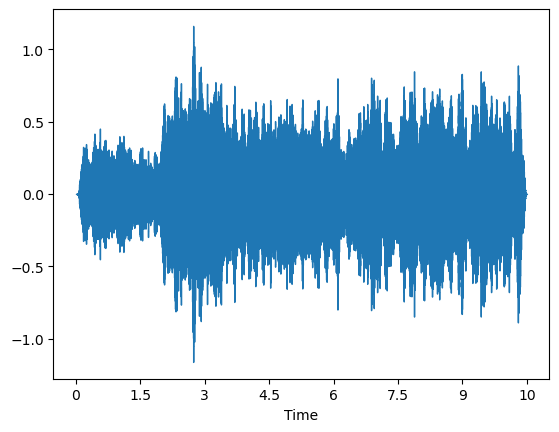

In [27]:
#@title Resynthesise
fade_length = 0.01 #@param {type: "number"}
#@markdown for emitter mode:
BPM = 140 #@param {type: "number"} BPM
beat_density = 1/64 #@param {type: "number"} grain emission rate in fractions of a beat
#@markdown for overlap mode:

density = (4 * beat_density * 60 / BPM)
print(f"Grain density: {density} seconds")
# Apply a Hann window to each frame
g_frames = np.array([frame * scipy.signal.hann(frame_length) for frame in g_frames], dtype=object)

out = dense_concatenate(g_frames, sr, density) # concatenate the grains
librosa.display.waveshow(out, sr=sr) # display the waveform
play = IPython.display.Audio(out, rate=sr) # play audio file using ipython display
IPython.display.display(play)

### 3.3 Save audio

In [28]:
#@title Save audio
if SAVE:
    filename = name #@param {type: "string"}
    filename += f"-generation-{sequence_length}-tokens-{beat_density}n-{BPM}-BPM.wav"
    output_path = "/Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/output" #@param {type:"string"}
    output_path += ("/" + filename)
    print("Saving", output_path)
    sf.write(output_path, out, sr) # write audio file to disk

Saving /Users/wwerkowicz/GS/MC/MC-FP/MC-FP-master/output/flux-generation-256-tokens-0.015625n-140-BPM.wav
